In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import time
from google.cloud import storage

#preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import SimpleImputer
#model
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from prophet import Prophet

#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [5]:
# filename = "../website-visitor_20231209.csv"
# df = pd.read_csv(filename)
# df['event_date'] = pd.to_datetime(df['event_date'], format='%Y%m%d')
# df = df.rename(columns={'event_date': 'date', 'f0_': 'count'}, inplace=False)

In [50]:
# Function to create lagged features for time series data
def create_lagged_features(data, lag):
    lagged_data = data.copy()
    for i in range(1, lag + 1):
        lagged_data[f'Lag_{i}'] = data['count'].shift(i)
    return lagged_data

def data_process_stats(df, train_index, test_index):
    time_series = df['count']
    train_data, test_data = time_series[train_index], time_series[test_index]
    return train_data, test_data

def data_process_ml(df, train_index, test_index):
    
    df = df.set_index('date', inplace=False)

    lag = 7  # Number of lagged values, adjust as needed
    # Apply the function to create lagged features
    lagged_df = create_lagged_features(df, lag)
    
    X = lagged_df.drop(['count'], axis=1)
    y = lagged_df['count']
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    
    return X_train, y_train, X_test, y_test, lagged_df
    
def data_process_prophet(df, train_index, test_index):
    df = df.rename(columns={'date': 'ds', 'count': 'y'}, inplace=False)
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]
    return train_data, test_data

# Model model
def model_exponential_smoothing(train_data, test_data):
    model = ExponentialSmoothing(train_data, seasonal="add", seasonal_periods=7)
    fit = model.fit()
    y_pred = fit.forecast(steps=len(test_data)) 
    return y_pred

def model_auto_arima(train_data, test_data):
    auto_model = auto_arima(train_data, seasonal=True, m=7, trace=True)
    n_forecast = len(test_data)
    y_pred, conf_int = auto_model.predict(n_forecast, return_conf_int=True)
    return y_pred

def model_linear_regression(X_train, y_train, X_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred
    
def model_lgb(X_train, y_train, X_test):
    model = lgb.LGBMRegressor(verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred
    
def model_xgboost(X_train, y_train, X_test):
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def model_prophet(train_data_pr, test_data_pr):
    model = Prophet()
    model.fit(train_data_pr)
    y_pred = model.predict(test_data_pr)
    return y_pred['yhat']

def produce_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return [mae, rmse, mape]


# Read Website Visitor Data

In [239]:
from google.cloud import bigquery


In [240]:
relative_path = '../../deep-flash-sa.json'
file_path = os.path.abspath(relative_path)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = file_path
storage_client = storage.Client()

In [241]:
project_id = "perqara-data"
dataset_name = "analytics_378351297"
table_name = "events_*"

In [242]:
bq_sql_query = f"""SELECT
  event_date,
  COUNT(DISTINCT value)
FROM (
  SELECT
    event_date,
    event_name,
    event_timestamp,
    b.key,
    COALESCE(CAST(b.value.int_value AS string),CAST(b.value.string_value AS string), CAST(b.value.float_value AS string), CAST(b.value.double_value AS string)) value
  FROM
    `{project_id}.{dataset_name}.{table_name}` a,
    UNNEST(event_params) b)
WHERE
  KEY = 'ga_session_id'
GROUP BY
  1
ORDER BY
  1"""

In [243]:
client = bigquery.Client()
query_job = client.query(
                bq_sql_query,
                # Location must match that of the dataset(s) referenced in the query.
                location="US",)
result = query_job.result()
df_web_visitor = result.to_dataframe()

In [244]:
df_web_visitor
df_web_visitor['event_date'] = pd.to_datetime(df_web_visitor['event_date'], format='%Y%m%d')
df_web_visitor = df_web_visitor.rename(columns={'event_date': 'date', 'f0_': 'count'}, inplace=False)

In [245]:
df_web_visitor

,date,count
0,2023-06-26,527
1,2023-06-27,485
2,2023-06-28,404
3,2023-06-29,328
4,2023-06-30,344
...,...,...
165,2023-12-08,499
166,2023-12-09,363
167,2023-12-10,345
168,2023-12-11,568


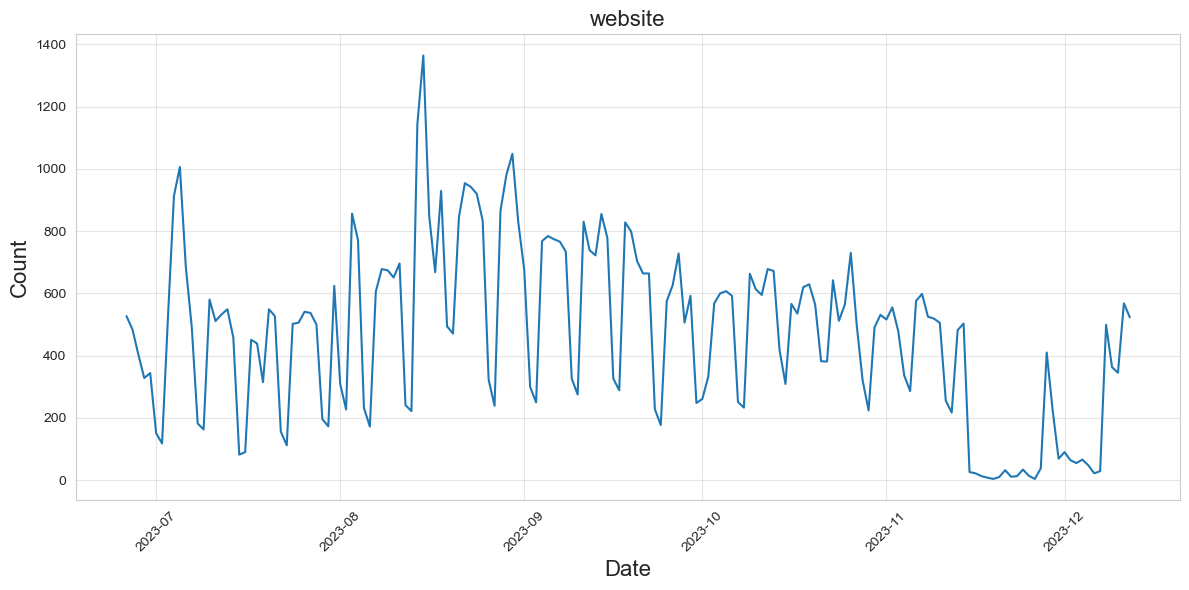

In [246]:
# Set a Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("tab10")

# Create a line plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.lineplot(data=df_web_visitor, x='date', y='count')

# Customize the plot
plt.title('website', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add grid lines
plt.grid(True, alpha=0.5)

# Show the plot
plt.tight_layout()  # Ensure all elements fit nicely
plt.show()

In [247]:
# problem
# the are problem data because of tech problem, so it will replace by forecasting value from 2023-11-14 to 2023-12-08

In [248]:
df_web_visitor[df_web_visitor['date'] > '2023-11-14']
df_web_visitor[df_web_visitor['date'] < '2023-12-08']

,date,count
0,2023-06-26,527
1,2023-06-27,485
2,2023-06-28,404
3,2023-06-29,328
4,2023-06-30,344
...,...,...
160,2023-12-03,55
161,2023-12-04,66
162,2023-12-05,48
163,2023-12-06,22


# Add exogenous variable


In [249]:
import gspread 
from oauth2client.service_account import ServiceAccountCredentials

spreadsheet_key = "1KZJmFezoZlc9drr-y5grwWE3u9UMqMSzAafzq89Ky7w"
scope = "https://spreadsheets.google.com/feeds"
credential = "./ads-sheets-notebook-47e00ba6aad5.json"

credentials = ServiceAccountCredentials.from_json_keyfile_name(credential, scope)
worksheet = gspread.authorize(credentials).open_by_key(spreadsheet_key).worksheet("ads")
data = worksheet.get_all_values()
headers = data.pop(0)
df = pd.DataFrame(data, columns=headers)

df_ads = df[['date','cost_google', 'cost_meta']].copy()
df_ads['date'] = pd.to_datetime(df_ads['date'])
df_ads['cost_google'] = df_ads['cost_google'].astype(int)
df_ads['cost_meta'] = df_ads['cost_meta'].astype(int)
df_ads.head()

,date,cost_google,cost_meta
0,2023-07-01,0,294981
1,2023-07-02,0,309988
2,2023-07-03,267006,287749
3,2023-07-04,259442,287421
4,2023-07-05,252299,302301


In [250]:
df_web_filter = df_web_visitor[df_web_visitor['date'] < '2023-11-15']
df_web_filter

,date,count
0,2023-06-26,527
1,2023-06-27,485
2,2023-06-28,404
3,2023-06-29,328
4,2023-06-30,344
...,...,...
137,2023-11-10,505
138,2023-11-11,255
139,2023-11-12,217
140,2023-11-13,482


In [251]:
def create_lagged_features(data, lag):
    lagged_data = data.copy()
    for i in range(1, lag + 1):
        lagged_data[f'lag_{i}'] = data['count'].shift(i)
    return lagged_data

In [252]:
df_ml = create_lagged_features(df_web_filter, 7)
df_ml = df_ml.fillna(df_ml.mean(numeric_only=True).round())
df_ml = df_ml[5:] # to match row with other variable
df_ml.head()

,date,count,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
5,2023-07-01,151,344,328,404,485,527,539,539
6,2023-07-02,118,151,344,328,404,485,527,539
7,2023-07-03,526,118,151,344,328,404,485,527
8,2023-07-04,913,526,118,151,344,328,404,485
9,2023-07-05,1006,913,526,118,151,344,328,404


In [253]:
df_merged = pd.merge(df_ml, df_ads, on='date', how='left')
df_merged = df_merged.set_index('date')

In [254]:
df_merged

,count,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,cost_google,cost_meta
date,,,,,,,,,,
2023-07-01,151,344,328,404,485,527,539,539,0,294981
2023-07-02,118,151,344,328,404,485,527,539,0,309988
2023-07-03,526,118,151,344,328,404,485,527,267006,287749
2023-07-04,913,526,118,151,344,328,404,485,259442,287421
2023-07-05,1006,913,526,118,151,344,328,404,252299,302301
...,...,...,...,...,...,...,...,...,...,...
2023-11-10,505,519,525,598,576,286,336,478,865900,0
2023-11-11,255,505,519,525,598,576,286,336,399045,0
2023-11-12,217,255,505,519,525,598,576,286,355873,0


In [255]:
# for i in range(7):
#     df_merged[f'cost_google_lag_{i+1}'] = df_merged['cost_google'].shift(i+1)
#     df_merged[f'cost_meta_lag_{i+1}'] = df_merged['cost_meta'].shift(i+1)
#     df_merged[f'cost_google_lag_{i+1}'] = df_merged[f'cost_google_lag_{i+1}'].fillna(df_merged[f'cost_google_lag_{i+1}'].mean())
#     df_merged[f'cost_meta_lag_{i+1}'] = df_merged[f'cost_meta_lag_{i+1}'].fillna(df_merged[f'cost_meta_lag_{i+1}'].mean())

In [256]:
scores_lr = []
scores_lgb = []
scores_xgb = []

n_splits = 5  # You can adjust the number of splits as needed
tscv = TimeSeriesSplit(n_splits=n_splits)
for i, (train_index, test_index) in enumerate(tscv.split(df_merged)):

    X = df_merged.drop(['count'], axis=1)
    y = df_merged['count']

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    y_pred_lr = model_linear_regression(X_train, y_train, X_test)
    y_pred_lgb = model_lgb(X_train, y_train, X_test)
    y_pred_xgb = model_xgboost(X_train, y_train, X_test)
    
    metrics_lr = produce_metrics(y_test, y_pred_lr)
    metrics_lgb = produce_metrics(y_test, y_pred_lgb)
    metrics_xgb = produce_metrics(y_test, y_pred_xgb)
    
    scores_lr.append(metrics_lr)
    scores_lgb.append(metrics_lgb)
    scores_xgb.append(metrics_xgb)
    
    print(f"Fold RMSE lr: {metrics_lr}")
    print(f"Fold RMSE lgb: {metrics_lgb}")
    print(f"Fold RMSE xgb: {metrics_xgb}")
    
print("Metrics lr:", scores_lr)
print("Metrics lgb:", scores_lgb)
print("Metrics xgb:", scores_xgb)

Fold RMSE lr: [134.16117737458035, 192.98723579052344, 0.27922854903265754]
Fold RMSE lgb: [301.909090909091, 358.00117092523374, 0.632179245437626]
Fold RMSE xgb: [178.22924839366567, 258.13576493206807, 0.2735223877079091]
Fold RMSE lr: [121.47566992068313, 147.0581656983564, 0.18920342878992244]
Fold RMSE lgb: [85.46358483342702, 110.13338032360252, 0.1271319010026774]
Fold RMSE xgb: [130.2613289572976, 148.4861247995397, 0.2109387541713688]
Fold RMSE lr: [90.86878726605913, 105.93974508439331, 0.18258145380690252]
Fold RMSE lgb: [84.80868734652854, 99.28963908002814, 0.17157161191109324]
Fold RMSE xgb: [97.0536942915483, 124.68496298781542, 0.18442118939663332]
Fold RMSE lr: [62.48815089239044, 74.59718111652717, 0.13401287416222532]
Fold RMSE lgb: [75.52359454799972, 92.09618668880302, 0.16934716454004364]
Fold RMSE xgb: [69.45495952259411, 86.5988046502704, 0.1468014082403157]
Fold RMSE lr: [309.5139046287004, 352.6131559821108, 0.7004587172925252]
Fold RMSE lgb: [111.90325629406

In [257]:
def metrics_results(model_score):
    num_rows = len(model_score)
    # Initialize a list to store the column sums
    column_sums = []

    # Calculate the sum of each column
    for col in range(len(model_score[0])):
        col_sum = sum(row[col] for row in model_score)
        column_sums.append(col_sum / num_rows)

    return column_sums

avg_lr = metrics_results(scores_lr)
avg_lgb = metrics_results(scores_lgb)
avg_xgb = metrics_results(scores_xgb)

# Create a Pandas DataFrame
df_model = pd.DataFrame({'Model': ['Linear Regression', 'LightGBM', 'XGBoost']})
df_res = pd.DataFrame([avg_lr, avg_lgb, avg_xgb])
df_res.columns = ['MAE', 'RMSE', 'MAPE']
df_final_scores = pd.concat([df_model, df_res], axis=1)
df_final_scores

,Model,MAE,RMSE,MAPE
0,Linear Regression,143.701538,174.639097,0.297097
1,LightGBM,131.921643,160.375129,0.284784
2,XGBoost,123.233720,156.841168,0.243757


## Generate synthetic data from '2023-11-14' to '2023-12-08'

In [287]:
def create_forecast_frame(feature_data, forecast_horizon):
    start_date = pd.to_datetime(feature_data.index[-1]) + pd.DateOffset(days=1)
    date_range = pd.date_range(start_date, periods=forecast_horizon, freq='D')
    forecast_df = pd.DataFrame(index=date_range, columns=["forecasted_value"])
    return forecast_df

def forecast(model, feature_data, forecast_temp, forecast_horizon):
    forecast_array = []
    columns_to_append = ['cost_google', 'cost_meta']

    latest_data_row = feature_data.iloc[-1, 0:7].to_numpy().reshape(1, -1)

    for i in range(forecast_horizon):
        latest_data_row = np.append(latest_data_row, forecast_temp[columns_to_append].iloc[i])
        latest_data_row = latest_data_row.reshape(1, -1)
        predicted_result = model.predict(latest_data_row)

        new_data_row = np.concatenate((predicted_result, latest_data_row[0]))

        forecast_array.append(new_data_row)

        latest_data_row = new_data_row[0:7].reshape(1, -1)

    forecast_value = [array[0] for array in forecast_array]
    forecast_temp["forecasted_value"] = forecast_value
    
    return forecast_temp

In [264]:
X = df_merged.drop('count', axis=1)
y = df_merged['count']

model_xgb = xgb.XGBRegressor()
model_xgb.fit(X, y)

In [453]:
filtered_df

,cost_google,cost_meta
date,,
2023-11-15,419316,0
2023-11-16,512278,0
2023-11-17,430062,0
2023-11-18,401130,0
2023-11-19,398602,0
2023-11-20,862843,0
2023-11-21,736666,0
2023-11-22,664467,0
2023-11-23,770460,0


In [302]:
forecast_df = create_forecast_frame(df_merged, 23)

# Define the date range
start_date = '2023-11-14'
end_date = '2023-12-08'

# Filter the DataFrame based on the date range
filtered_df = df_ads[(df_ads['date'] > start_date) & (df_ads['date'] < end_date)]
filtered_df.set_index('date', inplace=True)

forecast_template = pd.merge(forecast_df, filtered_df, left_index=True, right_index=True)
result = forecast(model_xgb, df_merged, forecast_template, 23)
result.reset_index(inplace=True)
result['forecasted_value'] = result['forecasted_value'].astype(int)

# Filter the DataFrame based on the date range and create a copy
filtered_subset = df_web_visitor[(df_web_visitor['date'] > start_date) & (df_web_visitor['date'] < end_date)].copy()

# Assign values to the 'count' column in the copied DataFrame
filtered_subset.loc[:, 'count'] = result['forecasted_value'].values

df_web_vis = df_web_visitor.copy()
df_web_vis_start = df_web_vis[df_web_vis['date'] <= '2023-11-14']
df_web_vis_end = df_web_vis[df_web_vis['date'] >= '2023-12-08']

df_web_merge = pd.concat([df_web_vis_start, filtered_subset], ignore_index=True, sort=False)
df_web_merge = pd.concat([df_web_merge, df_web_vis_end], ignore_index=True, sort=False)
df_web_merge = df_web_merge.sort_values(by='date')

<Axes: >

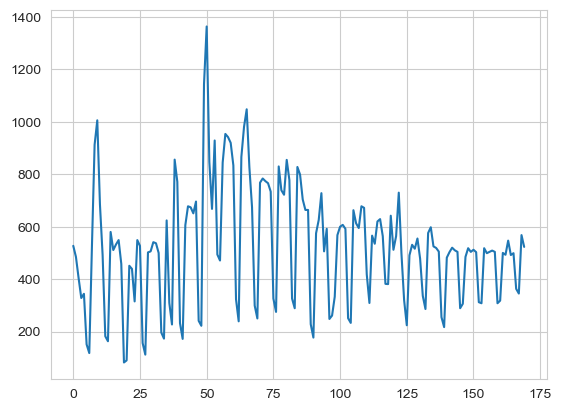

In [449]:
df_web_merge['count'].plot()

In [450]:
df_web_merge.to_csv('website-visitor-synthetic.csv', index=False)

In [189]:
until = 5
avg_lr = metrics_results(scores_lr[0:until])
avg_lgb = metrics_results(scores_lgb[0:until])
avg_xgb = metrics_results(scores_xgb[0:until])
avg_prophet = metrics_results(scores_prophet[0:until])



# Create a Pandas DataFrame
df_model = pd.DataFrame({'Model': ['Linear Regression', 'LightGBM', 'XGBoost', 'Prophet']})
df_res = pd.DataFrame([avg_lr, avg_lgb, avg_xgb, avg_prophet])
df_res.columns = ['MAE', 'RMSE', 'MAPE']
df_final_scores = pd.concat([df_model, df_res], axis=1)
df_final_scores

,Model,MAE,RMSE,MAPE
0,Linear Regression,143.701538,174.639097,0.297097
1,LightGBM,131.921643,160.375129,0.284784
2,XGBoost,123.233720,156.841168,0.243757
3,Prophet,140.148874,166.353465,0.308278


In [145]:
df_prophet = df_merged.reset_index()
df_prophet = df_prophet[['date', 'count', 'cost_google', 'cost_meta']]
df_prophet = df_prophet.rename(columns={'date':'ds', 'count':'y'})

In [186]:
df_prophet

,count,cost_google,cost_meta
date,,,
2023-07-01,151,0,294981
2023-07-02,118,0,309988
2023-07-03,526,267006,287749
2023-07-04,913,259442,287421
2023-07-05,1006,252299,302301
...,...,...,...
2023-11-10,505,865900,0
2023-11-11,255,399045,0
2023-11-12,217,355873,0


In [150]:
model = Prophet()
model.add_regressor('cost_google')
model.add_regressor('cost_meta')
model.fit(df)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [158]:
df_prophet = df_merged[['count', 'cost_google', 'cost_meta']]

In [188]:
df_prophet

,count,cost_google,cost_meta
date,,,
2023-07-01,151,0,294981
2023-07-02,118,0,309988
2023-07-03,526,267006,287749
2023-07-04,913,259442,287421
2023-07-05,1006,252299,302301
...,...,...,...
2023-11-10,505,865900,0
2023-11-11,255,399045,0
2023-11-12,217,355873,0


In [160]:
exogenous_features = list(df_prophet.iloc[:, 1:].columns)

n_splits = 5  # You can adjust the number of splits as needed
tscv = TimeSeriesSplit(n_splits=n_splits)

scores_prophet = []

df = df_prophet.copy()
df.reset_index(inplace=True)

for i, (train_index, test_index) in enumerate(tscv.split(df)):
    print(f"Fold {i}:")
    print(train_index)
    print(test_index)
    
    train_data_pr, test_data_pr = df.iloc[train_index], df.iloc[test_index]
    model = Prophet()
    for feature in exogenous_features:
        model.add_regressor(feature)
    
    model.fit(train_data_pr[["date", "count"] + exogenous_features].rename(columns={"date": "ds", "count": "y"}))
    y_pred = model.predict(test_data_pr[["date", "count"] + exogenous_features].rename(columns={"date": "ds", "count": "y"}))
    y_pred_new = y_pred['yhat']
        
    metrics_prophet = produce_metrics(test_data_pr['count'], y_pred_new)
    
    scores_prophet.append(metrics_prophet)
    
    print(f"Fold metrics prophet: {scores_prophet}")
    
print("Metrics prophet:", scores_prophet)

15:12:50 - cmdstanpy - INFO - Chain [1] start processing


Fold 0:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
[27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]


15:12:50 - cmdstanpy - INFO - Chain [1] done processing
15:12:50 - cmdstanpy - INFO - Chain [1] start processing
15:12:51 - cmdstanpy - INFO - Chain [1] done processing
15:12:51 - cmdstanpy - INFO - Chain [1] start processing


Fold metrics prophet: [[170.6289400376056, 206.26254316647623, 0.44381308473106207]]
Fold 1:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]
[49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70]
Fold metrics prophet: [[170.6289400376056, 206.26254316647623, 0.44381308473106207], [128.14142573130835, 158.51567587891984, 0.2415032385762329]]
Fold 2:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70]
[71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]


15:12:51 - cmdstanpy - INFO - Chain [1] done processing
15:12:51 - cmdstanpy - INFO - Chain [1] start processing


Fold metrics prophet: [[170.6289400376056, 206.26254316647623, 0.44381308473106207], [128.14142573130835, 158.51567587891984, 0.2415032385762329], [82.6029273234847, 94.53920221681328, 0.17579809118923437]]
Fold 3:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]
[ 93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114]


15:12:51 - cmdstanpy - INFO - Chain [1] done processing
15:12:51 - cmdstanpy - INFO - Chain [1] start processing
15:12:51 - cmdstanpy - INFO - Chain [1] done processing


Fold metrics prophet: [[170.6289400376056, 206.26254316647623, 0.44381308473106207], [128.14142573130835, 158.51567587891984, 0.2415032385762329], [82.6029273234847, 94.53920221681328, 0.17579809118923437], [62.077046672907414, 75.34968446977096, 0.132689577933]]
Fold 4:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114]
[115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136]
Fold metrics prophet: [[170.6289400376056, 206.26254316647623, 0.44381308473106207], [128.14142573130835, 158.51567587891984, 0.2415032385762329], [82.6029273234847, 94.

In [190]:
model

In [218]:
future = model.make_future_dataframe(periods=1)

In [209]:
future['cost_google'] = df_merged['cost_google']
future['cost_meta'] = df_merged['cost_meta']

In [202]:
forecast = model.predict(future)

ValueError: Found NaN in column 'cost_google'

In [237]:
df_merged = df_merged[['cost_google', 'cost_meta']]
df_merged

,cost_google,cost_meta
date,,
2023-07-01,0,294981
2023-07-02,0,309988
2023-07-03,267006,287749
2023-07-04,259442,287421
2023-07-05,252299,302301
...,...,...
2023-11-10,865900,0
2023-11-11,399045,0
2023-11-12,355873,0


In [238]:
df_merged

,cost_google,cost_meta
date,,
2023-07-01,0,294981
2023-07-02,0,309988
2023-07-03,267006,287749
2023-07-04,259442,287421
2023-07-05,252299,302301
...,...,...
2023-11-10,865900,0
2023-11-11,399045,0
2023-11-12,355873,0


In [208]:
df_merged['cost_google']

date
2023-07-01         0
2023-07-02         0
2023-07-03    267006
2023-07-04    259442
2023-07-05    252299
               ...  
2023-11-10    865900
2023-11-11    399045
2023-11-12    355873
2023-11-13    895773
2023-11-14    914510
Name: cost_google, Length: 137, dtype: int64

In [105]:
import joblib
#save model
joblib.dump(model_lr, 'linear_regression_model_web.pkl')

['linear_regression_model_web.pkl']

In [40]:
# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

# # Create a MinMaxScaler
# # scaler = MinMaxScaler()
# scaler = StandardScaler()


# X_train.loc[:, 'cost_google'] = scaler.fit_transform(X_train.loc[:, 'cost_google'].values.reshape(-1, 1))
# X_train.loc[:, 'cost_meta'] = scaler.fit_transform(X_train.loc[:, 'cost_meta'].values.reshape(-1, 1))


Text(0, 0.5, 'Importance')

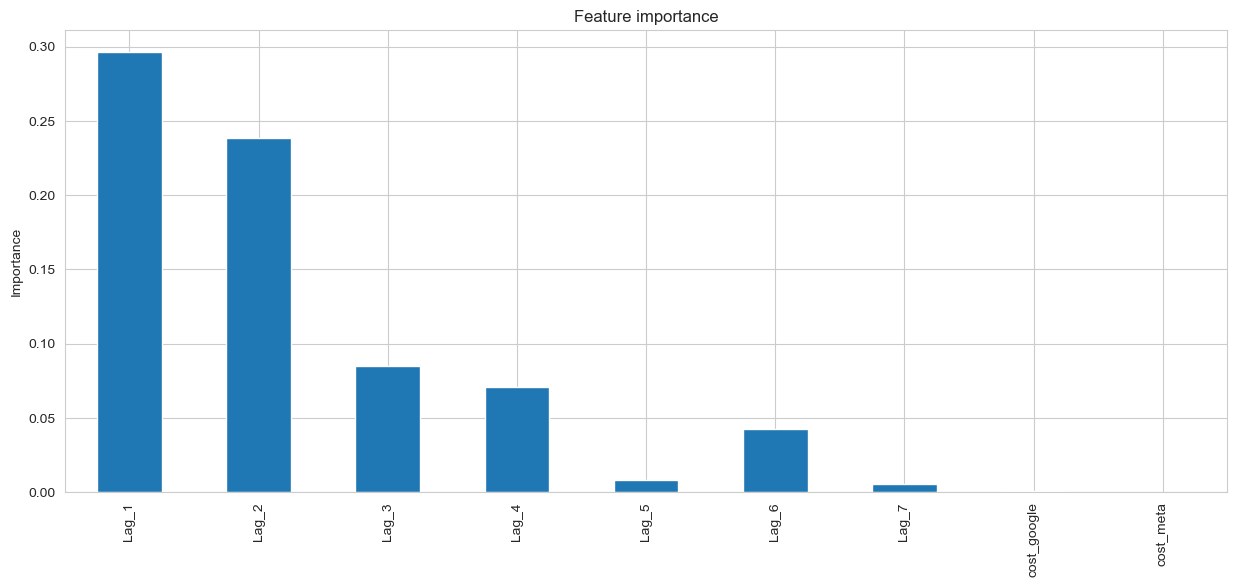

In [147]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

tmp = pd.Series(np.abs(model_lr.coef_))
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")

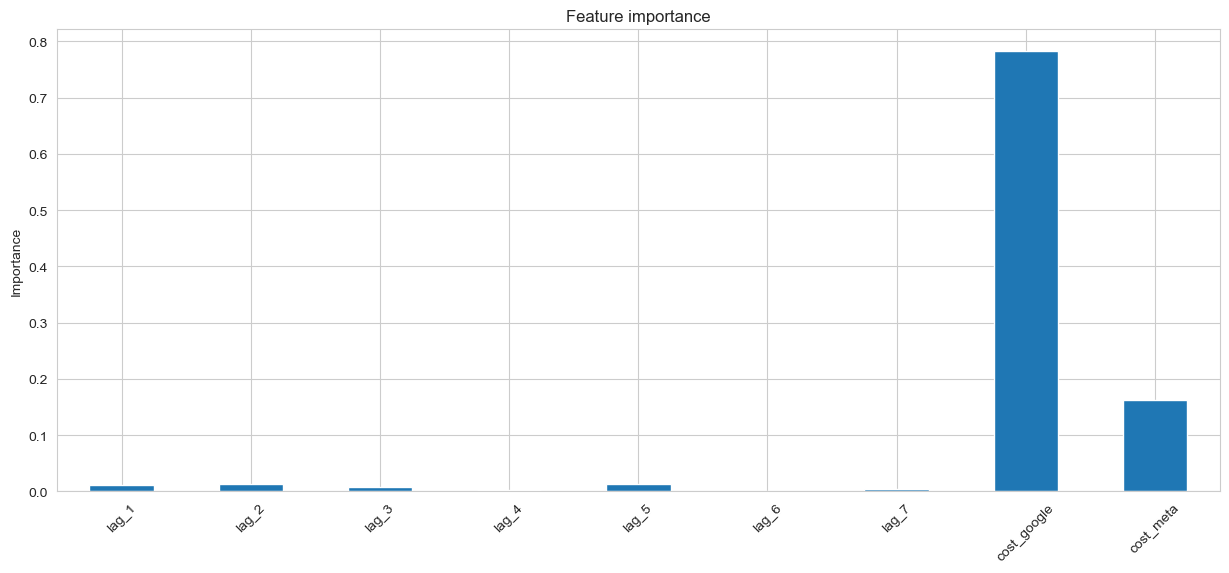

In [129]:
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)

tmp = pd.Series(model_xgb.feature_importances_)
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")

# Rotate the y-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.show()


In [99]:
import pickle

with open('xgb_model.pkl', 'wb') as model_file:
    pickle.dump(model_xgb, model_file)

In [104]:
with open('xgb_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

In [106]:
loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [114]:
with open('../model_lr.pkl', 'wb') as file:
    pickle.dump(model_lr, file)

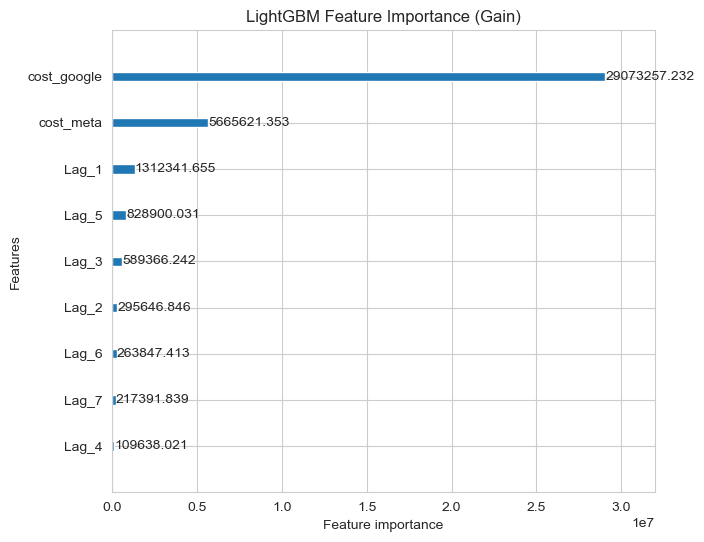

In [149]:
model = lgb.LGBMRegressor(verbose=-1)
model.fit(X_train, y_train)
# Plot feature importance using Gain
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()


In [154]:
df_merged.to_csv('../df_merged.csv', index=True)

## Forecast Future using linear regression


In [156]:
#add projection 
df_google_proj = pd.read_csv('../20231025-ads-google-proj.csv') 
df_meta_proj = pd.read_csv('../20231025-ads-meta-proj.csv')
df_google_proj = df_google_proj.rename(columns={'cost': 'cost_google'}, inplace=False)
df_meta_proj = df_meta_proj.rename(columns={'cost': 'cost_meta'}, inplace=False)

df_meta_proj= df_meta_proj[26:]
df_google_proj= df_google_proj[26:]

In [197]:
forecast_horizon = 47

start_date = df_merged.index.max() + pd.Timedelta(days=1)
date_range = pd.date_range(start_date, periods=forecast_horizon, freq='D')
forecast_df = pd.DataFrame(index=date_range, columns=["forecasted_value"])

forecast_array = []  # Renamed from 'forecast_value'
latest_data_row = df_merged.iloc[-1, 0:7].to_numpy().reshape(1, -1)

for i in range(forecast_horizon):
    
    latest_data_row_1 = np.append(latest_data_row, df_google_proj.iloc[i][1])
    latest_data_row_2 = np.append(latest_data_row_1, df_meta_proj.iloc[i][1])
    latest_data_row_3 = latest_data_row_2.reshape(1, -1)
    predicted_result = model_xgb.predict(latest_data_row_3)
    
    new_data_row = np.concatenate((predicted_result, latest_data_row_3[0]))
    print(new_data_row)
    forecast_array.append(new_data_row)
    
    latest_data_row = new_data_row[:-3].reshape(1, -1)
    
#     print(new_data_row)
    
forecast_value = [array[0] for array in forecast_array]
forecast_df["forecasted_value"] = forecast_value


[1.01759766e+03 5.03000000e+02 4.82000000e+02 2.17000000e+02
 2.55000000e+02 5.05000000e+02 5.19000000e+02 5.25000000e+02
 1.05000000e+06 6.00000000e+05]
[1.06997595e+03 1.01759766e+03 5.03000000e+02 4.82000000e+02
 2.17000000e+02 2.55000000e+02 5.05000000e+02 5.19000000e+02
 1.05000000e+06 6.00000000e+05]
[9.26341553e+02 1.06997595e+03 1.01759766e+03 5.03000000e+02
 4.82000000e+02 2.17000000e+02 2.55000000e+02 5.05000000e+02
 1.05000000e+06 6.00000000e+05]
[8.51191711e+02 9.26341553e+02 1.06997595e+03 1.01759766e+03
 5.03000000e+02 4.82000000e+02 2.17000000e+02 2.55000000e+02
 1.05000000e+06 6.00000000e+05]
[8.40296021e+02 8.51191711e+02 9.26341553e+02 1.06997595e+03
 1.01759766e+03 5.03000000e+02 4.82000000e+02 2.17000000e+02
 1.05000000e+06 6.00000000e+05]
[   418.03186035    840.29602051    851.19171143    926.34155273
   1069.97595215   1017.59765625    503.            482.
 100000.         100000.        ]
[   373.7913208     418.03186035    840.29602051    851.19171143
    926.3

In [196]:


# start_date = '2023-11-18'
# end_date = '2023-11-29'

# # Multiply the 'value' column by 3 for the specified date range
# forecast_df.loc[(forecast_df.index >= start_date) & (forecast_df.index <= end_date), 'value'] *= 3


KeyError: 'value'

In [232]:
factors = [1.1, 1.3, 1.5, 1.7, 2]

date_range_mask = (forecast_df.index >= '2023-11-18') & (forecast_df.index <= '2023-11-29')

for i, factor in enumerate(factors):
    forecast_df.loc[date_range_mask, f'forecasted_value_{i+1}'] = forecast_df.loc[date_range_mask, 'forecasted_value'] * factor

In [233]:
date_range_mask_1 = (forecast_df.index >= '2023-11-15') & (forecast_df.index <= '2023-11-17')
for i, factor in enumerate(factors):
    forecast_df.loc[date_range_mask_1, f'forecasted_value_{i+1}'] = forecast_df.loc[date_range_mask_1, 'forecasted_value']

In [234]:
date_range_mask_2 = forecast_df.index >= '2023-11-29'
for i, factor in enumerate(factors):
    forecast_df.loc[date_range_mask_2, f'forecasted_value_{i+1}'] = forecast_df.loc[date_range_mask_2, 'forecasted_value'] * 1.5

In [245]:
forecast_df

,forecasted_value,forecasted_value_1,forecasted_value_2,forecasted_value_3,forecasted_value_4,forecasted_value_5
2023-11-15,1017.597656,1017.597656,1017.597656,1017.597656,1017.597656,1017.597656
2023-11-16,1069.975952,1069.975952,1069.975952,1069.975952,1069.975952,1069.975952
2023-11-17,926.341553,926.341553,926.341553,926.341553,926.341553,926.341553
2023-11-18,851.191711,936.310883,1106.549225,1276.787567,1447.025909,1702.383423
2023-11-19,840.296021,924.325623,1092.384827,1260.444031,1428.503235,1680.592041
2023-11-20,418.031860,459.835046,543.441418,627.047791,710.654163,836.063721
2023-11-21,373.791321,411.170453,485.928717,560.686981,635.445245,747.582642
2023-11-22,975.347839,1072.882623,1267.952191,1463.021759,1658.091327,1950.695679
2023-11-23,1050.718262,1155.790088,1365.933740,1576.077393,1786.221045,2101.436523
2023-11-24,921.877380,1014.065118,1198.440594,1382.816071,1567.191547,1843.754761


In [237]:
forecast_df.sum()

forecasted_value      35650.811829
forecasted_value_1    48779.622736
forecasted_value_2    50374.441449
forecasted_value_3    51969.260162
forecasted_value_4    53564.078876
forecasted_value_5    55956.306946
dtype: float64

In [246]:
forecast_df

,forecasted_value,forecasted_value_1,forecasted_value_2,forecasted_value_3,forecasted_value_4,forecasted_value_5
2023-11-15,1017.597656,1017.597656,1017.597656,1017.597656,1017.597656,1017.597656
2023-11-16,1069.975952,1069.975952,1069.975952,1069.975952,1069.975952,1069.975952
2023-11-17,926.341553,926.341553,926.341553,926.341553,926.341553,926.341553
2023-11-18,851.191711,936.310883,1106.549225,1276.787567,1447.025909,1702.383423
2023-11-19,840.296021,924.325623,1092.384827,1260.444031,1428.503235,1680.592041
2023-11-20,418.031860,459.835046,543.441418,627.047791,710.654163,836.063721
2023-11-21,373.791321,411.170453,485.928717,560.686981,635.445245,747.582642
2023-11-22,975.347839,1072.882623,1267.952191,1463.021759,1658.091327,1950.695679
2023-11-23,1050.718262,1155.790088,1365.933740,1576.077393,1786.221045,2101.436523
2023-11-24,921.877380,1014.065118,1198.440594,1382.816071,1567.191547,1843.754761


In [185]:
# tanggal 18 - 29 
# 10%, 23
# setelah launch 1.5 

forecast_df['1.1%'] =  forecast_df['forecasted_value'] * 1.1
forecast_df['1.3%'] =  forecast_df['forecasted_value'] * 1.3
forecast_df['1.5%'] =  forecast_df['forecasted_value'] * 1.5
forecast_df['1.7%'] =  forecast_df['forecasted_value'] * 1.7
forecast_df['1.8%'] =  forecast_df['forecasted_value'] * 1.8
forecast_df['2%'] =  forecast_df['forecasted_value'] * 2

In [183]:
# Assuming forecast_df is your DataFrame
start_date = '2023-11-18'
end_date = '2023-11-29'

filtered_df = forecast_df.loc[(forecast_df.index >= start_date) & (forecast_df.index <= end_date)]


In [184]:
filtered_df

,forecasted_value,1.1%,1.3%,1.5%,1.7%,1.8%,1.2%
2023-11-18,851.191711,936.310883,1106.549225,1276.787567,1447.025909,1532.145081,1702.383423
2023-11-19,840.296021,924.325623,1092.384827,1260.444031,1428.503235,1512.532837,1680.592041
2023-11-20,418.031860,459.835046,543.441418,627.047791,710.654163,752.457349,836.063721
2023-11-21,373.791321,411.170453,485.928717,560.686981,635.445245,672.824377,747.582642
2023-11-22,975.347839,1072.882623,1267.952191,1463.021759,1658.091327,1755.626111,1950.695679
2023-11-23,1050.718262,1155.790088,1365.933740,1576.077393,1786.221045,1891.292871,2101.436523
2023-11-24,921.877380,1014.065118,1198.440594,1382.816071,1567.191547,1659.379285,1843.754761
2023-11-25,858.177979,943.995776,1115.631372,1287.266968,1458.902563,1544.720361,1716.355957
2023-11-26,852.099487,937.309436,1107.729333,1278.149231,1448.569128,1533.779077,1704.198975
2023-11-27,381.024506,419.126956,495.331857,571.536758,647.741660,685.844110,762.049011


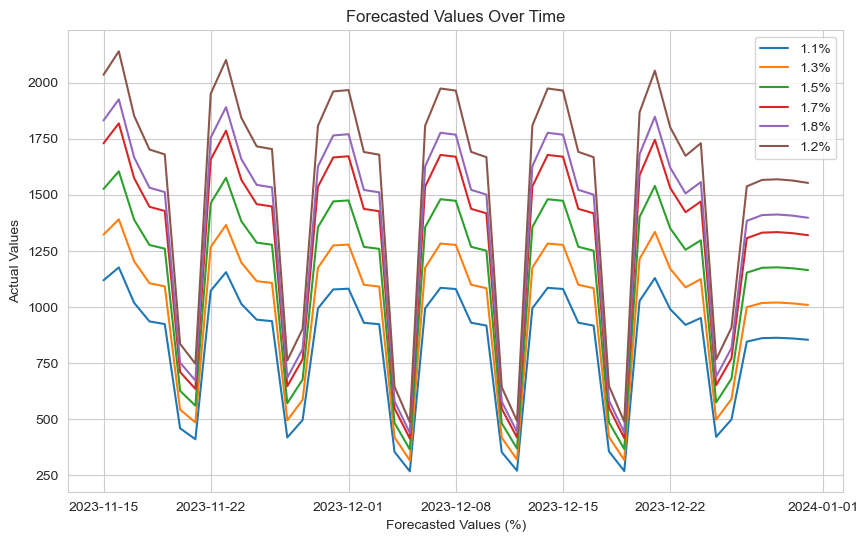

In [175]:
# Plotting
plt.figure(figsize=(10, 6))
for col in forecast_df.columns[1:]:
    plt.plot(forecast_df.index, forecast_df[col], label=col)

        
plt.title('Forecasted Values Over Time')
plt.xlabel('Forecasted Values (%)')
plt.ylabel('Actual Values')
plt.legend()
plt.show()

In [ ]:
forecast_horizon = 52

start_date = feature_web.index.max() + pd.Timedelta(days=1)
date_range = pd.date_range(start_date, periods=forecast_horizon, freq='D')
forecast_df = pd.DataFrame(index=date_range, columns=["forecasted_value"])

forecast_array = []  # Renamed from 'forecast_value'
latest_data_row = feature_web.iloc[-1, 0:7].to_numpy().reshape(1, -1)

for i in range(forecast_horizon):
    
    latest_data_row_1 = np.append(latest_data_row, df_google_proj.iloc[i][1])
    latest_data_row_2 = np.append(latest_data_row_1, df_meta_proj.iloc[i][1])
    latest_data_row_3 = latest_data_row_2.reshape(1, -1)
    predicted_result = model_xgb.predict(latest_data_row_3)
    
    new_data_row = np.concatenate((predicted_result, latest_data_row_3[0]))
    print(new_data_row)
    forecast_array.append(new_data_row)
    
    latest_data_row = new_data_row[:-3].reshape(1, -1)
    
#     print(new_data_row)
    
forecast_value = [array[0] for array in forecast_array]
forecast_df["forecasted_value"] = forecast_value

In [81]:
df_fr = df_merged.copy()

In [87]:
df_fr.to_csv('feature_web.csv',index=True)

In [100]:
feature_web = pd.read_csv('feature_web.csv')
feature_web['date'] = pd.to_datetime(feature_web['date'])
feature_web.set_index('date', inplace=True)

with open('xgb_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

forecast_horizon = 52

start_date = feature_web.index.max() + pd.Timedelta(days=1)
date_range = pd.date_range(start_date, periods=forecast_horizon, freq='D')
forecast_df = pd.DataFrame(index=date_range, columns=["forecasted_value"])

forecast_array = []  # Renamed from 'forecast_value'
latest_data_row = feature_web.iloc[-1, 0:7].to_numpy().reshape(1, -1)

for i in range(forecast_horizon):
    
    latest_data_row_1 = np.append(latest_data_row, df_google_proj.iloc[i][1])
    latest_data_row_2 = np.append(latest_data_row_1, df_meta_proj.iloc[i][1])
    latest_data_row_3 = latest_data_row_2.reshape(1, -1)
    predicted_result = model_xgb.predict(latest_data_row_3)
    
    new_data_row = np.concatenate((predicted_result, latest_data_row_3[0]))
    print(new_data_row)
    forecast_array.append(new_data_row)
    
    latest_data_row = new_data_row[:-3].reshape(1, -1)
    
#     print(new_data_row)
    
forecast_value = [array[0] for array in forecast_array]
forecast_df["forecasted_value"] = forecast_value

[6.79274902e+02 5.19000000e+02 5.25000000e+02 5.98000000e+02
 5.76000000e+02 2.86000000e+02 3.36000000e+02 4.78000000e+02
 7.10000000e+05 1.30000000e+05]
[6.92016418e+02 6.79274902e+02 5.19000000e+02 5.25000000e+02
 5.98000000e+02 5.76000000e+02 2.86000000e+02 3.36000000e+02
 7.10000000e+05 1.30000000e+05]
[6.91122620e+02 6.92016418e+02 6.79274902e+02 5.19000000e+02
 5.25000000e+02 5.98000000e+02 5.76000000e+02 2.86000000e+02
 7.10000000e+05 1.30000000e+05]
[   310.98251343    691.12261963    692.01641846    679.27490234
    519.            525.            598.            576.
 100000.         100000.        ]
[   227.25204468    310.98251343    691.12261963    692.01641846
    679.27490234    519.            525.            598.
 100000.         100000.        ]
[1.00267371e+03 2.27252045e+02 3.10982513e+02 6.91122620e+02
 6.92016418e+02 6.79274902e+02 5.19000000e+02 5.25000000e+02
 1.05000000e+06 6.00000000e+05]
[1.15791248e+03 1.00267371e+03 2.27252045e+02 3.10982513e+02
 6.91122620

In [ ]:
# tanggal 18 - 29 
# 10%, 23
# setelah launch 1.5 

forecast_df['1.1%'] =  forecast_df['forecasted_value'] * 1.1
forecast_df['1.3%'] =  forecast_df['forecasted_value'] * 1.3
forecast_df['1.5%'] =  forecast_df['forecasted_value'] * 1.5
forecast_df['1.7%'] =  forecast_df['forecasted_value'] * 1.7
forecast_df['1.8%'] =  forecast_df['forecasted_value'] * 1.8
forecast_df['1.2%'] =  forecast_df['forecasted_value'] * 2

In [129]:
forecast_df

,forecasted_value,1.2%,1.1%,1.3%,1.5%,1.7%,1.8%
2023-11-10,931.030891,1862.061782,1024.133980,1210.340158,1396.546336,1582.752515,1675.855604
2023-11-11,1050.442707,2100.885414,1155.486978,1365.575519,1575.664060,1785.752602,1890.796872
2023-11-12,1008.160819,2016.321638,1108.976901,1310.609065,1512.241228,1713.873392,1814.689474
2023-11-13,401.020532,802.041064,441.122585,521.326692,601.530798,681.734904,721.836958
2023-11-14,210.180012,420.360023,231.198013,273.234015,315.270018,357.306020,378.324021
2023-11-15,1358.722092,2717.444184,1494.594301,1766.338720,2038.083138,2309.827556,2445.699765
2023-11-16,1708.328303,3416.656606,1879.161133,2220.826794,2562.492454,2904.158115,3074.990945
2023-11-17,1563.754276,3127.508551,1720.129703,2032.880558,2345.631413,2658.382268,2814.757696
2023-11-18,1546.369235,3092.738470,1701.006158,2010.280005,2319.553852,2628.827699,2783.464623
2023-11-19,1497.303589,2994.607178,1647.033948,1946.494666,2245.955384,2545.416101,2695.146460


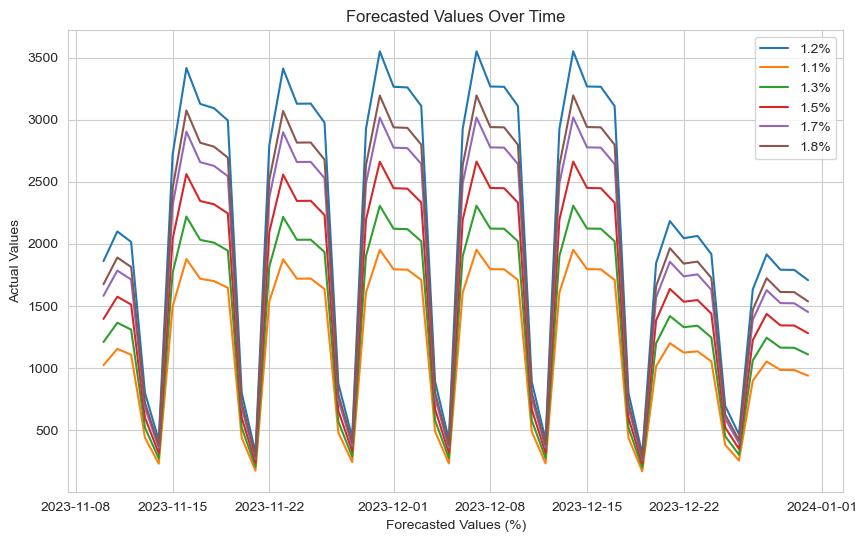

In [128]:
# Plotting
plt.figure(figsize=(10, 6))
for col in forecast_df.columns[1:]:
    plt.plot(forecast_df.index, forecast_df[col], label=col)

        
plt.title('Forecasted Values Over Time')
plt.xlabel('Forecasted Values (%)')
plt.ylabel('Actual Values')
plt.legend()
plt.show()

<Axes: >

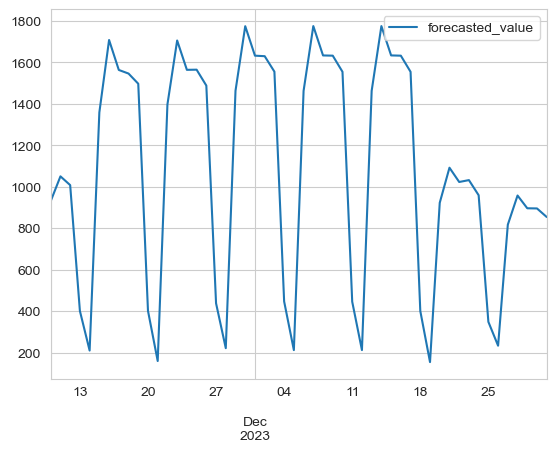

In [110]:
forecast_df.plot()

In [82]:
forecast_horizon = 52

start_date = df_fr.index.max() + pd.Timedelta(days=1)
date_range = pd.date_range(start_date, periods=forecast_horizon, freq='D')
forecast_df = pd.DataFrame(index=date_range, columns=["forecasted_value"])


In [102]:
forecast_array = []  # Renamed from 'forecast_value'
latest_data_row = df_fr.iloc[-1, 0:7].to_numpy().reshape(1, -1)

for i in range(forecast_horizon):
    
    latest_data_row_1 = np.append(latest_data_row, df_google_proj.iloc[i][1])
    latest_data_row_2 = np.append(latest_data_row_1, df_meta_proj.iloc[i][1])
    latest_data_row_3 = latest_data_row_2.reshape(1, -1)
    predicted_result = model_lr.predict(latest_data_row_3)
    
    new_data_row = np.concatenate((predicted_result, latest_data_row_3[0]))
    print(new_data_row)
    forecast_array.append(new_data_row)
    
    latest_data_row = new_data_row[:-3].reshape(1, -1)
    
#     print(new_data_row)
    
forecast_value = [array[0] for array in forecast_array]
forecast_df["forecasted_value"] = forecast_value

[9.31030891e+02 5.19000000e+02 5.25000000e+02 5.98000000e+02
 5.76000000e+02 2.86000000e+02 3.36000000e+02 4.78000000e+02
 7.10000000e+05 1.30000000e+05]
[1.05044271e+03 9.31030891e+02 5.19000000e+02 5.25000000e+02
 5.98000000e+02 5.76000000e+02 2.86000000e+02 3.36000000e+02
 7.10000000e+05 1.30000000e+05]
[1.00816082e+03 1.05044271e+03 9.31030891e+02 5.19000000e+02
 5.25000000e+02 5.98000000e+02 5.76000000e+02 2.86000000e+02
 7.10000000e+05 1.30000000e+05]
[   401.02053203   1008.16081899   1050.44270685    931.03089097
    519.            525.            598.            576.
 100000.         100000.        ]
[   210.18001173    401.02053203   1008.16081899   1050.44270685
    931.03089097    519.            525.            598.
 100000.         100000.        ]
[1.35872209e+03 2.10180012e+02 4.01020532e+02 1.00816082e+03
 1.05044271e+03 9.31030891e+02 5.19000000e+02 5.25000000e+02
 1.05000000e+06 6.00000000e+05]
[1.70832830e+03 1.35872209e+03 2.10180012e+02 4.01020532e+02
 1.00816082

/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid fea

In [84]:
forecast_df

,forecasted_value
2023-11-10,679.274902
2023-11-11,692.016418
2023-11-12,691.122620
2023-11-13,310.982513
2023-11-14,227.252045
2023-11-15,1002.673706
2023-11-16,1157.912476
2023-11-17,1077.873047
2023-11-18,869.133057
2023-11-19,860.590576


In [77]:
forecast_df.to_csv('webvisitor_forecast_2.csv')

In [79]:
model_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [72]:
# Create and fit a xgb Regression model
# model_xgb = model_lr()
model_xgb.fit(X_train, y_train)

# Make predictions on the test set
forecast_lr = model_xgb.predict(X_test)### 
alpha = 0.15
residuals = y_test - forecast_lr
mse = np.mean(residuals ** 2)
prediction_std = np.sqrt(mse)

n = len(X_test)
t_score = np.abs(np.percentile(np.random.standard_t(df=n-2, size=10000), 100 * (1 - alpha / 2)))

# Calculate the prediction interval for each data point
prediction_interval_lower = forecast_lr - t_score * prediction_std
prediction_interval_upper = forecast_lr + t_score * prediction_std

In [73]:
# Calculate the prediction interval for each data point
prediction_interval_lower = y_pred_lr - t_score * prediction_std
prediction_interval_upper = y_pred_lr + t_score * prediction_std

forecast_df['lower'] = forecast_df["forecasted_value"] - t_score * prediction_std
forecast_df['upper'] = forecast_df["forecasted_value"] + t_score * prediction_std


In [78]:
forecast_df['forecasted_value'].to_csv('webvisitor_forecast_1109.csv', index=True)

In [75]:
forecast_df

,forecasted_value,lower,upper
2023-11-10,679.274902,473.932484,884.617321
2023-11-11,692.016418,486.674000,897.358837
2023-11-12,691.122620,485.780201,896.465038
2023-11-13,310.982513,105.640095,516.324932
2023-11-14,227.252045,21.909626,432.594463
2023-11-15,1002.673706,797.331288,1208.016124
2023-11-16,1157.912476,952.570057,1363.254894
2023-11-17,1077.873047,872.530629,1283.215465
2023-11-18,869.133057,663.790638,1074.475475
2023-11-19,860.590576,655.248158,1065.932994


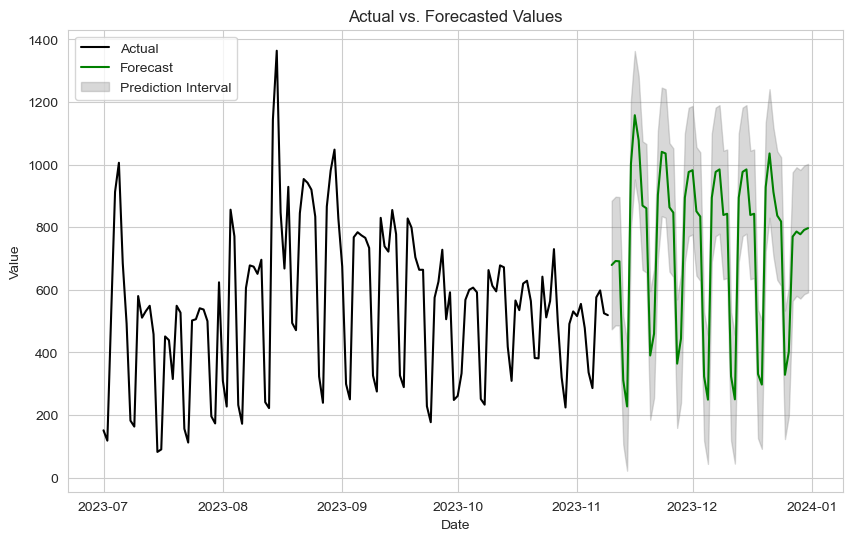

In [76]:
# Plot actual, training, and forecasted values for the test set
plt.figure(figsize=(10, 6))
plt.plot(df_merged.index, df_merged['count'], label='Actual', color='black')
plt.plot(forecast_df.index, forecast_df['forecasted_value'], label='Forecast', color='green')
# Add prediction intervals
plt.fill_between(forecast_df.index, forecast_df['lower'], forecast_df['upper'], color='gray', alpha=0.3, label='Prediction Interval')


plt.title('Actual vs. Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [13]:
# Create and fit a Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_lr.predict(X_test)### Linear regression 

alpha = 0.15
residuals = y_test - y_pred
mse = np.mean(residuals ** 2)
prediction_std = np.sqrt(mse)

n = len(X_test)
t_score = np.abs(np.percentile(np.random.standard_t(df=n-2, size=10000), 100 * (1 - alpha / 2)))

# Calculate the prediction interval for each data point
prediction_interval_lower = y_pred - t_score * prediction_std
prediction_interval_upper = y_pred + t_score * prediction_std

/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [24]:
lagged_df = lagged_df.fillna(lagged_df.mean())


In [31]:
# Define the number of days to forecast
forecast_horizon = 73

data_prep = lagged_df.copy()

start_date = data_prep.index.max() + pd.Timedelta(days=1)
date_range = pd.date_range(start_date, periods=forecast_horizon, freq='D')
forecast_df = pd.DataFrame(index=date_range, columns=["Forecasted_Value"])
forecast_df

forecast_array = []  # Renamed from 'forecast_value'
latest_data_row = data_prep.iloc[-1, 0:7].to_numpy().reshape(1, -1)

for i in range(forecast_horizon):
    predicted_result = model_lr.predict(latest_data_row)
    predicted_result = np.round(predicted_result).astype(int)
    last_index = len(latest_data_row) - 1
    new_data_row = np.concatenate((predicted_result, latest_data_row[0]))
    forecast_array.append(new_data_row)
    
    latest_data_row = new_data_row[:-1].reshape(1, -1)

forecast_value = [array[0] for array in forecast_array]

forecast_df["Forecasted_Value"] = forecast_value

In [38]:
forecast_df = forecast_df.reset_index()
forecast_df = forecast_df.rename(columns={'index': 'date'}, inplace=False)

In [39]:
forecast_df.to_csv('webvisitor_forecast.csv', index=False)

In [80]:
forecast_df

,forecasted_value,lower,upper
2023-10-20,830.099941,728.903042,931.296840
2023-10-21,896.151024,794.954125,997.347923
2023-10-22,885.707071,784.510172,986.903970
2023-10-23,354.030998,252.834099,455.227898
2023-10-24,199.381442,98.184543,300.578341
...,...,...,...
2023-12-27,808.627038,707.430139,909.823938
2023-12-28,959.053566,857.856667,1060.250465
2023-12-29,897.120842,795.923943,998.317741
2023-12-30,889.159346,787.962447,990.356245
